<a href="https://colab.research.google.com/github/erichardson97/cell_crushers/blob/main/modelling/modelling_functions_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive, files
import pandas as pd
from typing import Union, Callable
import numpy as np
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import pylab
import scipy.stats as stats
import os
import sklearn
# %pip install striprtf
# from striprtf.striprtf import rtf_to_text

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
os.chdir('/content/drive/MyDrive/Github/cell_crushers/modelling')
!git pull
import utils
from data_utils import Dataset
os.chdir('/content/drive/MyDrive/CMIPB_Files')

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), 756 bytes | 0 bytes/s, done.
From https://github.com/erichardson97/cell_crushers
   58ed7e5..8e992bc  main       -> origin/main
Updating 58ed7e5..8e992bc
Fast-forward
 modelling/utils.py | 6 +++---
 1 file changed, 3 insertions(+), 3 deletions(-)


In [3]:
# @title Read in file and specify target feature.

def load_data(path = '/content/drive/MyDrive/CMIPB_Files/IntegratedData.tsv', target = 'Day14_IgG_Titre'):
  data = pd.read_csv(path, sep = '\t', index_col = 0)
  data = data.rename(columns = {target: 'Target'})
  data = data[data['Target'].notna()]
  ds = Dataset(data)
  return ds

In [4]:
from scipy.stats import spearmanr, linregress

def calc_residuals_for_prediction(baseline, y):
  slope, intercept, r, p, se = linregress(baseline, y)
  residuals = [y_val - (p*slope + intercept) for p, y_val in zip(baseline, y)]
  return slope, intercept, np.array(residuals)

def residuals_model(base_class: sklearn.base.BaseEstimator):
  class ResidualModel(base_class):

    def __init__(self, **kwargs):
      super().__init__(**kwargs)

    def fit(self, X, y):
      baseline = X[:, -1]
      X = X[:, :-1]
      slope, intercept, residuals = calc_residuals_for_prediction(baseline, y)
      self.slope = slope
      self.intercept = intercept
      super().fit(X, residuals)

    def predict(self, X):
      baseline = X[:, -1]
      X = X[:, :-1]
      residuals = super().predict(X)
      return self.slope * baseline + self.intercept + residuals
  return ResidualModel

In [5]:
features_sans_target = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/features_sans_target.txt')['feature name'].values
demographic = ['age', 'biological_sex', 'infancy_vac', 'Titre_IgG_PT']
cell_freqs = ['Cellfrequency_TcmCD4', 'Cellfrequency_TemCD4', 'Cellfrequency_Bcells','Cellfrequency_ASCs (Plasmablasts)']
genes = [p for p in features_sans_target if 'GEX' in p]
cytokines = [p for p in features_sans_target if 'Cytokine' in p]
cytokines.remove('Cytokine_IFNG')
cytokines.remove('Cytokine_TNF')
candidate_features = cell_freqs + genes + cytokines + demographic

AttributeError: ignored

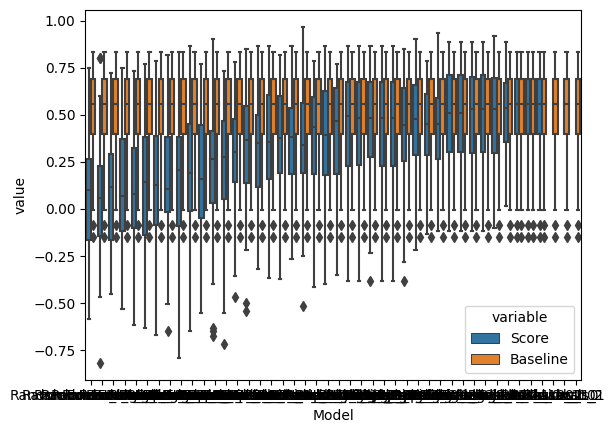

In [10]:
# @title Approach 1: Use all features. Try out LASSO, RandomForest, RidgeRegression. Directory name: KitchenSink.
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge


output_path = '/content/drive/MyDrive/CMIPB_Files/KitchenSink'
if os.path.exists(output_path) is False:
  os.mkdir(output_path)
candidate_features = candidate_features

###LASSO, Ridge
#alpha: [0.01, 0.1, 1, 2, 10]
model_params = {}
model_classes = {}
return_coef = {}

for alpha in [.01, 0.1, 1, 2, 10]:
  model_params[f'Lasso_{alpha}'] = {'alpha':alpha}
  model_classes[f'Lasso_{alpha}'] = Lasso
  model_params[f'Lasso_Residuals_{alpha}'] = {'alpha':alpha}
  model_classes[f'Lasso_Residuals_{alpha}'] = residuals_model(Lasso)
  model_params[f'Ridge_{alpha}'] = {'alpha':alpha}
  model_classes[f'Ridge_{alpha}'] = Ridge
  model_params[f'Ridge_Residuals_{alpha}'] = {'alpha':alpha}
  model_classes[f'Ridge_Residuals_{alpha}'] = residuals_model(Ridge)
for x in model_classes:
  return_coef[x] = 'coef_'


for params in ParameterGrid({'max_features':[None, 'sqrt', 'log2'], 'n_estimators':[10,50,100,150]}):
  max_feat = params['max_features']
  n_estimators = params['n_estimators']
  model_params[f'RandomForest_{max_feat}_{n_estimators}'] = params
  model_params[f'RandomForest_Residuals_{max_feat}_{n_estimators}'] = params
  model_classes[f'RandomForest_{max_feat}_{n_estimators}'] = RandomForestRegressor
  model_classes[f'RandomForest_Residuals_{max_feat}_{n_estimators}'] = residuals_model(RandomForestRegressor)
  return_coef[f'RandomForest_Residuals_{max_feat}_{n_estimators}'] = 'feature_importances_'
  return_coef[f'RandomForest_{max_feat}_{n_estimators}'] = 'feature_importances_'



# args_for_cv = {'target':'Target', 'n_splits':5, 'score_function':utils.corr_coeff_report, 'features':candidate_features,
#                'transformation':False, 'plot_dir':output_path, 'transformation_args':{}, 'model_params': model_params,
#                'model_classes':model_classes, 'return_coef':return_coef}

# assert candidate_features[-1] == 'Titre_IgG_PT'

# ds = load_data()
# ds.filter(candidate_features)
# cvobj = utils.CV(ds.data[candidate_features+['Target']])
# total = []
# coefs_ = []
# for f in range(10):
#   args_for_cv['plot_dir'] = os.path.join(output_path, f'Fold{f}')
#   if os.path.exists(args_for_cv['plot_dir']) is False:
#     os.mkdir(args_for_cv['plot_dir'])
#   output, _, coefs = cvobj.RunCV(cv_type='RegularCV', cv_args = args_for_cv)
#   output['repeat'] = f
#   coefs['repeat'] = f
#   total.append(output)
#   coefs_.append(coefs)
#   output.to_csv(os.path.join(args_for_cv['plot_dir'], f'Performance{f}.csv'))
#   coefs.to_csv(os.path.join(args_for_cv['plot_dir'], f'FeatureImportance{f}.csv'))
# total = pd.concat(total)
# total.to_csv(os.path.join(output_path, f'PerformanceTotal.csv'))
order = total.groupby('Model').apply(lambda x:(x['Score'] - x['Baseline']).mean()).sort_values().index
ax = sns.boxplot(data = total.melt(id_vars=['Model'], value_vars=['Score', 'Baseline']), x = 'Model', y = 'value', hue = 'variable', order = order)
for tick in ax.get_xticklabels():
  tick.set_rotation(90)
plt.savefig(os.path.join(output_path, 'Values.png'), dpi = 600, bbox_inches = 'tight')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.884e-03, tolerance: 3.700e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.010e-02, tolerance: 2.782e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e-02, tolerance: 3.700e

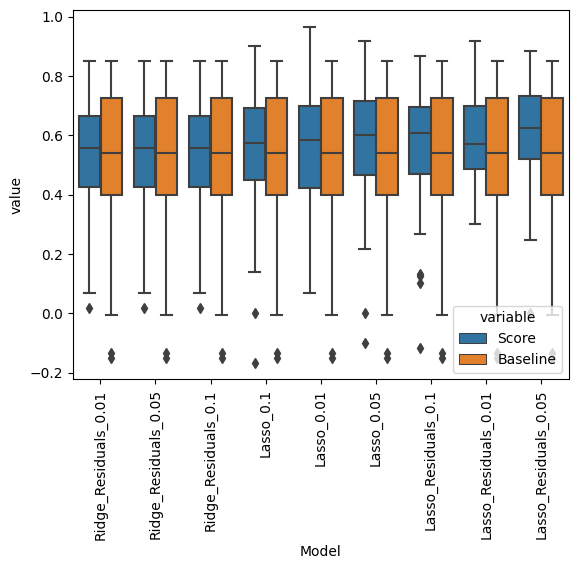

In [16]:
output_path = '/content/drive/MyDrive/CMIPB_Files/KitchenSink_LogTransformed'
if os.path.exists(output_path) is False:
  os.mkdir(output_path)

filtered_genes = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/Features/FilteredGenes.txt')['feature name'].unique()
features_sans_target = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/features_sans_target.txt')['feature name'].values
demographic = ['age', 'biological_sex', 'infancy_vac', 'Titre_IgG_PT']
cell_freqs = ['Cellfrequency_TcmCD4', 'Cellfrequency_TemCD4', 'Cellfrequency_Bcells','Cellfrequency_ASCs (Plasmablasts)']
cytokines = [p for p in features_sans_target if 'Cytokine' in p]
cytokines.remove('Cytokine_IFNG')
cytokines.remove('Cytokine_TNF')
candidate_features = list([p for p in features_sans_target if 'GEX' in p]) + cell_freqs + cytokines + demographic


model_params = {}
model_classes = {}
return_coef = {}

for alpha in [.01, 0.05, 0.1]:
  model_params[f'Lasso_{alpha}'] = {'alpha':alpha}
  model_classes[f'Lasso_{alpha}'] = Lasso
  model_params[f'Lasso_Residuals_{alpha}'] = {'alpha':alpha}
  model_classes[f'Lasso_Residuals_{alpha}'] = residuals_model(Lasso)
  model_params[f'Ridge_{alpha}'] = {'alpha':alpha}
  model_params[f'Ridge_Residuals_{alpha}'] = {'alpha':alpha}
  model_classes[f'Ridge_Residuals_{alpha}'] = residuals_model(Ridge)
for x in model_classes:
  return_coef[x] = 'coef_'



args_for_cv = {'target':'Target', 'n_splits':5, 'score_function':utils.corr_coeff_report, 'features':candidate_features,
               'transformation':False, 'plot_dir':output_path, 'transformation_args':{}, 'model_params': model_params,
               'model_classes':model_classes, 'return_coef': return_coef}

ds = load_data('/content/drive/MyDrive/CMIPB_Files/IntegratedData_Normalized.tsv')
ds.filter(candidate_features+['Target'])
ds.data['Target'] = ds.data['Target'].map(float).map(np.log)
ds.data['Titre_IgG_PT'] = ds.data['Titre_IgG_PT'].map(float).map(np.log)
assert candidate_features[-1] == 'Titre_IgG_PT'


cvobj = utils.CV(ds.data[candidate_features+['Target']])
total = []
coefs_ = []
for f in range(10):
  args_for_cv['precomputed_split'] = f'/content/drive/MyDrive/CMIPB_Files/KitchenSink/Fold{f}/CV_Idx.p'
  args_for_cv['plot_dir'] = os.path.join(output_path, f'Fold{f}')
  if os.path.exists(args_for_cv['plot_dir']) is False:
    os.mkdir(args_for_cv['plot_dir'])
  output, _, coefs = cvobj.RunCV(cv_type='RegularCV', cv_args = args_for_cv)
  output['repeat'] = f
  coefs['repeat'] = f
  total.append(output)
  coefs_.append(coefs)
  output.to_csv(os.path.join(args_for_cv['plot_dir'], f'Performance{f}.csv'))
  coefs.to_csv(os.path.join(args_for_cv['plot_dir'], f'FeatureImportance{f}.csv'))
total = pd.concat(total)
total.to_csv(os.path.join(output_path, f'PerformanceTotal.csv'))
order = total.groupby('Model').apply(lambda x:(x['Score'] - x['Baseline']).mean()).sort_values().index
ax = sns.boxplot(data = total.melt(id_vars=['Model'], value_vars=['Score', 'Baseline']), x = 'Model', y = 'value', hue = 'variable', order = order)
for tick in ax.get_xticklabels():
  tick.set_rotation(90)
plt.savefig(os.path.join(output_path, 'Values.png'), dpi = 600, bbox_inches = 'tight')

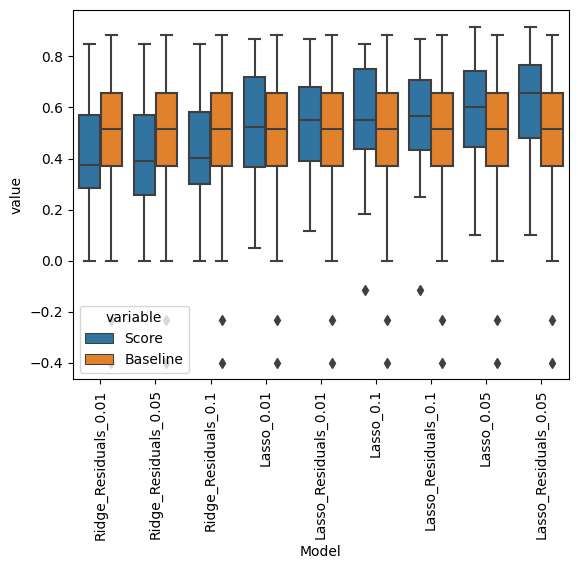

In [13]:
output_path = '/content/drive/MyDrive/CMIPB_Files/KitchenSink_LogTransformed_FilteredNonCorrelatedGenes'
if os.path.exists(output_path) is False:
  os.mkdir(output_path)




model_params = {}
model_classes = {}
return_coef = {}

for alpha in [.01, 0.05, 0.1]:
  model_params[f'Lasso_{alpha}'] = {'alpha':alpha}
  model_classes[f'Lasso_{alpha}'] = Lasso
  model_params[f'Lasso_Residuals_{alpha}'] = {'alpha':alpha}
  model_classes[f'Lasso_Residuals_{alpha}'] = residuals_model(Lasso)
  model_params[f'Ridge_{alpha}'] = {'alpha':alpha}
  model_params[f'Ridge_Residuals_{alpha}'] = {'alpha':alpha}
  model_classes[f'Ridge_Residuals_{alpha}'] = residuals_model(Ridge)
for x in model_classes:
  return_coef[x] = 'coef_'



ds = load_data('/content/drive/MyDrive/CMIPB_Files/Features_NormalizedData/DataWithCorrelationFiltering.tsv')



features_sans_target = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/features_sans_target.txt')['feature name'].values
demographic = ['age', 'biological_sex', 'infancy_vac', 'Titre_IgG_PT']
cell_freqs = ['Cellfrequency_TcmCD4', 'Cellfrequency_TemCD4', 'Cellfrequency_Bcells','Cellfrequency_ASCs (Plasmablasts)']
cytokines = [p for p in features_sans_target if 'Cytokine' in p]
cytokines.remove('Cytokine_IFNG')
cytokines.remove('Cytokine_TNF')
candidate_features = list([p for p in ds.data if 'GEX' in p]) + cell_freqs + cytokines + demographic

ds.filter(candidate_features+['Target'])
ds.data['Target'] = ds.data['Target'].map(float).map(np.log)
ds.data['Titre_IgG_PT'] = ds.data['Titre_IgG_PT'].map(float).map(np.log)
assert candidate_features[-1] == 'Titre_IgG_PT'

args_for_cv = {'target':'Target', 'n_splits':5, 'score_function':utils.corr_coeff_report, 'features':candidate_features,
               'transformation':False, 'plot_dir':output_path, 'transformation_args':{}, 'model_params': model_params,
               'model_classes':model_classes, 'return_coef': return_coef}

cvobj = utils.CV(ds.data[candidate_features+['Target']])
total = []
coefs_ = []
for f in range(10):
  args_for_cv['precomputed_split'] = f'/content/drive/MyDrive/CMIPB_Files/KitchenSink/Fold{f}/CV_Idx.p'
  args_for_cv['plot_dir'] = os.path.join(output_path, f'Fold{f}')
  if os.path.exists(args_for_cv['plot_dir']) is False:
    os.mkdir(args_for_cv['plot_dir'])
  output, _, coefs = cvobj.RunCV(cv_type='RegularCV', cv_args = args_for_cv)
  output['repeat'] = f
  coefs['repeat'] = f
  total.append(output)
  coefs_.append(coefs)
  output.to_csv(os.path.join(args_for_cv['plot_dir'], f'Performance{f}.csv'))
  coefs.to_csv(os.path.join(args_for_cv['plot_dir'], f'FeatureImportance{f}.csv'))
total = pd.concat(total)
total.to_csv(os.path.join(output_path, f'PerformanceTotal.csv'))
order = total.groupby('Model').apply(lambda x:(x['Score'] - x['Baseline']).mean()).sort_values().index
ax = sns.boxplot(data = total.melt(id_vars=['Model'], value_vars=['Score', 'Baseline']), x = 'Model', y = 'value', hue = 'variable', order = order)
for tick in ax.get_xticklabels():
  tick.set_rotation(90)
plt.savefig(os.path.join(output_path, 'Values.png'), dpi = 600, bbox_inches = 'tight')

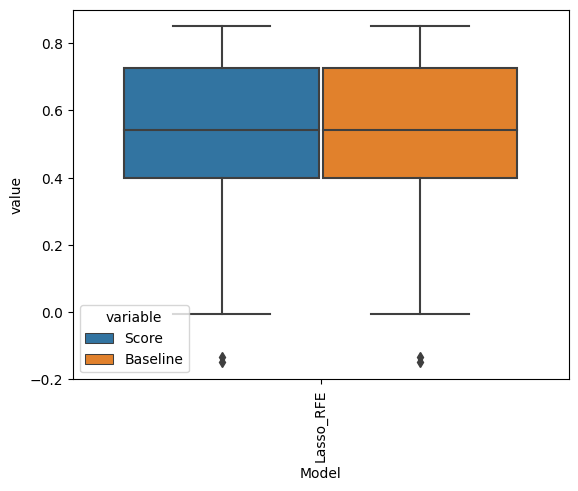

In [31]:
from sklearn.feature_selection import RFE

output_path = '/content/drive/MyDrive/CMIPB_Files/KitchenSink_LogTransformed_FilteredNonCorrelatedGenes_RFE_LassoResiduals_0.1_0.5'
if os.path.exists(output_path) is False:
  os.mkdir(output_path)



model_params = {'Lasso_RFE':{'estimator':residuals_model(Lasso)(alpha=0.1), 'n_features_to_select':0.5}}
model_classes = {'Lasso_RFE':RFE}
return_coef = {}
for x in model_classes:
  return_coef[x] = 'ranking_'



ds = load_data('/content/drive/MyDrive/CMIPB_Files/Features_NormalizedData/DataWithCorrelationFiltering.tsv')



features_sans_target = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/features_sans_target.txt')['feature name'].values
demographic = ['age', 'biological_sex', 'infancy_vac', 'Titre_IgG_PT']
cell_freqs = ['Cellfrequency_TcmCD4', 'Cellfrequency_TemCD4', 'Cellfrequency_Bcells','Cellfrequency_ASCs (Plasmablasts)']
cytokines = [p for p in features_sans_target if 'Cytokine' in p]
cytokines.remove('Cytokine_IFNG')
cytokines.remove('Cytokine_TNF')
candidate_features = list([p for p in ds.data if 'GEX' in p]) + cell_freqs + cytokines + demographic

ds.filter(candidate_features+['Target'])
ds.data['Target'] = ds.data['Target'].map(float).map(np.log)
ds.data['Titre_IgG_PT'] = ds.data['Titre_IgG_PT'].map(float).map(np.log)
assert candidate_features[-1] == 'Titre_IgG_PT'

args_for_cv = {'target':'Target', 'n_splits':5, 'score_function':utils.corr_coeff_report, 'features':candidate_features,
               'transformation':False, 'plot_dir':output_path, 'transformation_args':{}, 'model_params': model_params,
               'model_classes':model_classes, 'return_coef': return_coef}

cvobj = utils.CV(ds.data[candidate_features+['Target']])
total = []
coefs_ = []
for f in range(10):
  args_for_cv['precomputed_split'] = f'/content/drive/MyDrive/CMIPB_Files/KitchenSink/Fold{f}/CV_Idx.p'
  args_for_cv['plot_dir'] = os.path.join(output_path, f'Fold{f}')
  if os.path.exists(args_for_cv['plot_dir']) is False:
    os.mkdir(args_for_cv['plot_dir'])
  output, _, coefs = cvobj.RunCV(cv_type='RegularCV', cv_args = args_for_cv)
  output['repeat'] = f
  coefs['repeat'] = f
  total.append(output)
  coefs_.append(coefs)
  output.to_csv(os.path.join(args_for_cv['plot_dir'], f'Performance{f}.csv'))
  coefs.to_csv(os.path.join(args_for_cv['plot_dir'], f'FeatureImportance{f}.csv'))
total = pd.concat(total)
total.to_csv(os.path.join(output_path, f'PerformanceTotal.csv'))
order = total.groupby('Model').apply(lambda x:(x['Score'] - x['Baseline']).mean()).sort_values().index
ax = sns.boxplot(data = total.melt(id_vars=['Model'], value_vars=['Score', 'Baseline']), x = 'Model', y = 'value', hue = 'variable', order = order)
for tick in ax.get_xticklabels():
  tick.set_rotation(90)
plt.savefig(os.path.join(output_path, 'Values.png'), dpi = 600, bbox_inches = 'tight')

/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 35
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 36
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 36
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 36
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 36
  warnings.warn(f"Y residual is constant at iteration {k}")
/usr/local/lib/python3.10/dist-pack

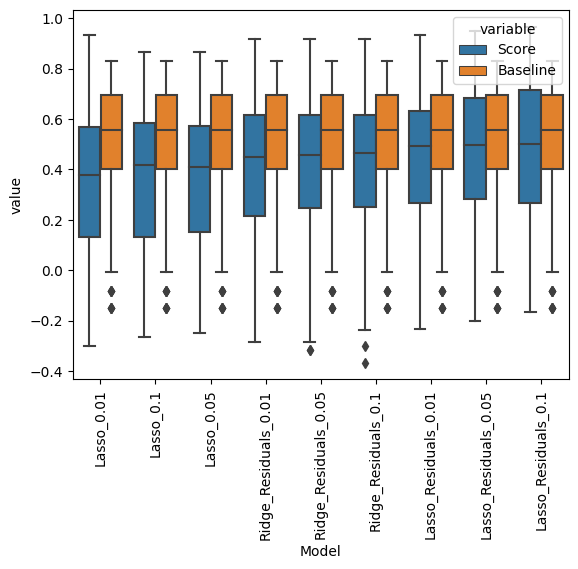

In [10]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA

output_path = '/content/drive/MyDrive/CMIPB_Files/KitchenSink_LogTransformed_FilteredGenes_PLS'

if os.path.exists(output_path) is False:
  os.mkdir(output_path)

filtered_genes = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/Features/FilteredGenes.txt')['feature name'].unique()
features_sans_target = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/features_sans_target.txt')['feature name'].values
demographic = ['age', 'biological_sex', 'infancy_vac', 'Titre_IgG_PT']
cell_freqs = ['Cellfrequency_TcmCD4', 'Cellfrequency_TemCD4', 'Cellfrequency_Bcells','Cellfrequency_ASCs (Plasmablasts)']
cytokines = [p for p in features_sans_target if 'Cytokine' in p]
cytokines.remove('Cytokine_IFNG')
cytokines.remove('Cytokine_TNF')
candidate_features = list(filtered_genes) + cell_freqs + cytokines + demographic


model_params = {}
model_classes = {}
return_coef = {}

for alpha in [.01, 0.05, 0.1]:
  model_params[f'Lasso_{alpha}'] = {'alpha':alpha}
  model_classes[f'Lasso_{alpha}'] = Lasso
  model_params[f'Lasso_Residuals_{alpha}'] = {'alpha':alpha}
  model_classes[f'Lasso_Residuals_{alpha}'] = residuals_model(Lasso)
  model_params[f'Ridge_{alpha}'] = {'alpha':alpha}
  model_params[f'Ridge_Residuals_{alpha}'] = {'alpha':alpha}
  model_classes[f'Ridge_Residuals_{alpha}'] = residuals_model(Ridge)
for x in model_classes:
  return_coef[x] = 'coef_'





ds = load_data('/content/drive/MyDrive/CMIPB_Files/IntegratedData_Normalized.tsv')
ds.filter(candidate_features+['Target'])
ds.data['Target'] = ds.data['Target'].map(float).map(np.log)
ds.data['Titre_IgG_PT'] = ds.data['Titre_IgG_PT'].map(float).map(np.log)
assert candidate_features[-1] == 'Titre_IgG_PT'

def reduce_dimensions(X: np.array, y: np.array, features: np.array, features_to_change: np.array, n_components: int, reducer, trained: bool = False, supervised: bool = True):
    feature_idxs = np.where(np.isin(features, features_to_change))[0]
    features_to_keep = np.where(~np.isin(features, features_to_change))[0]
    if not trained:
      reduction = reducer(n_components = n_components)
      if supervised:
        X_trans = reduction.fit(X[:, feature_idxs], y).transform(X[:, feature_idxs])
      else:
        X_trans = reduction.fit(X[:, feature_idxs]).transform(X[:, feature_idxs])
    else:
      reduction = reducer
      X_trans = reduction.transform(X[:, feature_idxs])
    X_new = np.hstack([X_trans, X[:, features_to_keep]])
    new_feature_order = [f'NewFeat{p}' for p in range(n_components)] + list(features[features_to_keep])
    return X_new, reduction, new_feature_order

args_for_cv = {'target':'Target', 'n_splits':5, 'score_function':utils.corr_coeff_report, 'features':candidate_features,
               'transformation':utils.reduce_dimensions, 'plot_dir':output_path, 'transformation_args':{'features':np.array(candidate_features),'features_to_change' : np.array(filtered_genes),
              'reducer':PLSRegression}, 'model_params': model_params,
                'model_classes':model_classes, 'return_coef':return_coef}


ds = load_data()
ds.filter(candidate_features)
cvobj = utils.CV(ds.data[candidate_features+['Target']])
total = []
coefs_ = []
for f in range(10):
  args_for_cv['precomputed_split'] = f'/content/drive/MyDrive/CMIPB_Files/KitchenSink/Fold{f}/CV_Idx.p'
  for n_dim in [50, 25, 10, 5]:
    args_for_cv['plot_dir'] = os.path.join(output_path, f'Run{f}')
    args_for_cv['transformation_args']['n_components'] = n_dim
    if os.path.exists(os.path.join(output_path, f'Run{f}')) is False:
      os.mkdir(os.path.join(output_path, f'Run{f}'))
    output, _, coefs = cvobj.RunCV(cv_type='RegularCV', cv_args = args_for_cv)
    output['repeat'] = f
    output['n_dim'] = n_dim
    total.append(output)
    coefs['repeat'] = f
    coefs['n_dim'] = n_dim
    coefs_.append(coefs)
    output.to_csv(os.path.join(args_for_cv['plot_dir'],f'Performance{f}_NDim{n_dim}.csv'))
    coefs.to_csv(os.path.join(args_for_cv['plot_dir'], f'FeatureImportance{f}_NDim{n_dim}.csv'))
total = pd.concat(total)
total.to_csv(os.path.join(output_path, f'Performance_Total.csv'))

order = total.groupby('Model').apply(lambda x:(x['Score'] - x['Baseline']).mean()).sort_values().index
ax = sns.boxplot(data = total.melt(id_vars=['Model'], value_vars=['Score', 'Baseline']), x = 'Model', y = 'value', hue = 'variable', order = order)
for tick in ax.get_xticklabels():
  tick.set_rotation(90)
plt.savefig(os.path.join(output_path, 'Values.png'), dpi = 600, bbox_inches = 'tight')

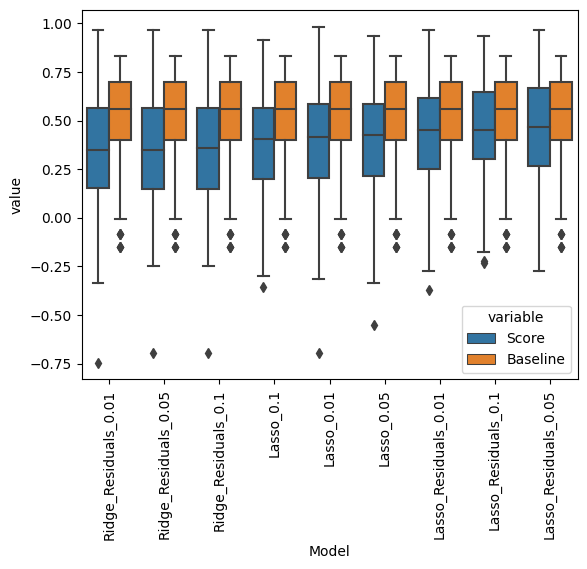

In [12]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA

output_path = '/content/drive/MyDrive/CMIPB_Files/KitchenSink_LogTransformed_FilteredGenes_PCA'

if os.path.exists(output_path) is False:
  os.mkdir(output_path)

filtered_genes = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/Features/FilteredGenes.txt')['feature name'].unique()
features_sans_target = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/features_sans_target.txt')['feature name'].values
demographic = ['age', 'biological_sex', 'infancy_vac', 'Titre_IgG_PT']
cell_freqs = ['Cellfrequency_TcmCD4', 'Cellfrequency_TemCD4', 'Cellfrequency_Bcells','Cellfrequency_ASCs (Plasmablasts)']
cytokines = [p for p in features_sans_target if 'Cytokine' in p]
cytokines.remove('Cytokine_IFNG')
cytokines.remove('Cytokine_TNF')
candidate_features = list(filtered_genes) + cell_freqs + cytokines + demographic


model_params = {}
model_classes = {}
return_coef = {}

for alpha in [.01, 0.05, 0.1]:
  model_params[f'Lasso_{alpha}'] = {'alpha':alpha}
  model_classes[f'Lasso_{alpha}'] = Lasso
  model_params[f'Lasso_Residuals_{alpha}'] = {'alpha':alpha}
  model_classes[f'Lasso_Residuals_{alpha}'] = residuals_model(Lasso)
  model_params[f'Ridge_{alpha}'] = {'alpha':alpha}
  model_params[f'Ridge_Residuals_{alpha}'] = {'alpha':alpha}
  model_classes[f'Ridge_Residuals_{alpha}'] = residuals_model(Ridge)
for x in model_classes:
  return_coef[x] = 'coef_'





ds = load_data('/content/drive/MyDrive/CMIPB_Files/IntegratedData_Normalized.tsv')
ds.filter(candidate_features+['Target'])
ds.data['Target'] = ds.data['Target'].map(float).map(np.log)
ds.data['Titre_IgG_PT'] = ds.data['Titre_IgG_PT'].map(float).map(np.log)
assert candidate_features[-1] == 'Titre_IgG_PT'

def reduce_dimensions(X: np.array, y: np.array, features: np.array, features_to_change: np.array, n_components: int, reducer, trained: bool = False, supervised: bool = True):
    feature_idxs = np.where(np.isin(features, features_to_change))[0]
    features_to_keep = np.where(~np.isin(features, features_to_change))[0]
    if not trained:
      reduction = reducer(n_components = n_components)
      if supervised:
        X_trans = reduction.fit(X[:, feature_idxs], y).transform(X[:, feature_idxs])
      else:
        X_trans = reduction.fit(X[:, feature_idxs]).transform(X[:, feature_idxs])
    else:
      reduction = reducer
      X_trans = reduction.transform(X[:, feature_idxs])
    X_new = np.hstack([X_trans, X[:, features_to_keep]])
    new_feature_order = [f'NewFeat{p}' for p in range(n_components)] + list(features[features_to_keep])
    return X_new, reduction, new_feature_order

args_for_cv = {'target':'Target', 'n_splits':5, 'score_function':utils.corr_coeff_report, 'features':candidate_features,
               'transformation':utils.reduce_dimensions, 'plot_dir':output_path, 'transformation_args':{'features':np.array(candidate_features),'features_to_change' : np.array(filtered_genes), 'supervised':False,
              'reducer':PCA}, 'model_params': model_params,
                'model_classes':model_classes, 'return_coef':return_coef}


ds = load_data()
ds.filter(candidate_features)
cvobj = utils.CV(ds.data[candidate_features+['Target']])
total = []
coefs_ = []
for f in range(10):
  args_for_cv['precomputed_split'] = f'/content/drive/MyDrive/CMIPB_Files/KitchenSink/Fold{f}/CV_Idx.p'
  for n_dim in [30, 10, 5]:
    args_for_cv['plot_dir'] = os.path.join(output_path, f'Run{f}')
    args_for_cv['transformation_args']['n_components'] = n_dim
    if os.path.exists(os.path.join(output_path, f'Run{f}')) is False:
      os.mkdir(os.path.join(output_path, f'Run{f}'))
    output, _, coefs = cvobj.RunCV(cv_type='RegularCV', cv_args = args_for_cv)
    output['repeat'] = f
    output['n_dim'] = n_dim
    total.append(output)
    coefs['repeat'] = f
    coefs['n_dim'] = n_dim
    coefs_.append(coefs)
    output.to_csv(os.path.join(args_for_cv['plot_dir'],f'Performance{f}_NDim{n_dim}.csv'))
    coefs.to_csv(os.path.join(args_for_cv['plot_dir'], f'FeatureImportance{f}_NDim{n_dim}.csv'))
total = pd.concat(total)
total.to_csv(os.path.join(output_path, f'Performance_Total.csv'))

order = total.groupby('Model').apply(lambda x:(x['Score'] - x['Baseline']).mean()).sort_values().index
ax = sns.boxplot(data = total.melt(id_vars=['Model'], value_vars=['Score', 'Baseline']), x = 'Model', y = 'value', hue = 'variable', order = order)
for tick in ax.get_xticklabels():
  tick.set_rotation(90)
plt.savefig(os.path.join(output_path, 'Values.png'), dpi = 600, bbox_inches = 'tight')

In [9]:
coefs['f']

,NewFeat0,NewFeat1,NewFeat2,NewFeat3,NewFeat4,NewFeat5,NewFeat6,NewFeat7,NewFeat8,NewFeat9,...,Cellfrequency_ASCs (Plasmablasts),Cytokine_CCL3,Cytokine_CXCL10,Cytokine_CCL8,Cytokine_IL6,age,biological_sex,infancy_vac,Titre_IgG_PT,Fold
Lasso_0.01,-0.211096,0.110268,-0.119889,0.149465,0.113707,-0.090218,0.073222,0.045588,-0.041142,-0.035383,...,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.0,0
Lasso_Residuals_0.01,-0.195319,0.104258,-0.078980,0.148262,0.087678,-0.077130,0.050178,-0.012383,-0.027643,0.004580,...,0.078217,-0.000000,0.000000,-0.000000,0.000000,0.020223,-0.000000,-0.086444,NaN,0
Ridge_Residuals_0.01,-0.174939,0.101871,-0.073191,0.145260,0.077785,-0.067847,0.057212,-0.007813,-0.025346,0.024468,...,0.036822,-0.027341,-0.021304,-0.006581,0.034375,0.066483,0.003698,-0.064225,NaN,0
Lasso_0.05,-0.206497,0.107358,-0.116402,0.141917,0.105015,-0.081605,0.063345,0.038499,-0.025321,-0.019667,...,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.0,0
Lasso_Residuals_0.05,-0.203176,0.097570,-0.075487,0.136852,0.081146,-0.059886,0.042088,-0.005568,-0.012407,-0.000000,...,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.015816,-0.000000,-0.000000,NaN,0
Ridge_Residuals_0.05,-0.174933,0.101862,-0.073186,0.145221,0.077767,-0.067827,0.057200,-0.007815,-0.025340,0.024444,...,0.036780,-0.027330,-0.021301,-0.006560,0.034359,0.066441,0.003701,-0.064164,NaN,0
Lasso_0.1,-0.200749,0.103720,-0.112043,0.132483,0.094149,-0.070838,0.050998,0.029637,-0.005544,-0.000021,...,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.0,0
Lasso_Residuals_0.1,-0.200502,0.094343,-0.071119,0.127304,0.071536,-0.048347,0.029632,-0.000000,-0.000000,-0.000000,...,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,NaN,0
Ridge_Residuals_0.1,-0.174924,0.101852,-0.073180,0.145173,0.077744,-0.067801,0.057186,-0.007818,-0.025333,0.024414,...,0.036726,-0.027316,-0.021297,-0.006533,0.034339,0.066388,0.003706,-0.064088,NaN,0
Lasso_0.01,0.230365,0.223604,-0.101875,-0.157060,-0.029640,0.041489,0.060360,-0.067498,-0.051322,0.049945,...,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.0,1


In [13]:
out = cvobj.RunCV(cv_type='RegularCV', cv_args = args_for_cv)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.639e-03, tolerance: 2.464e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e-02, tolerance: 2.514e-03
  model = cd_fast.enet_coordinate_descent(


TypeError: ignored

In [79]:

ds = load_data('/content/drive/MyDrive/CMIPB_Files/IntegratedData_Normalized.tsv')

In [80]:
ds.data

,Cellfrequency_Monocytes,Cellfrequency_Classical_Monocytes,Cellfrequency_Non-Classical_Monocytes,Cellfrequency_Intermediate_Monocytes,Cellfrequency_Bcells,Cellfrequency_CD3CD19,Cellfrequency_CD3CD19neg,Cellfrequency_CD3 Tcells,Cellfrequency_CD4Tcells,Cellfrequency_CD8Tcells,...,Titre_IgG4_TT,Titre_IgG4_DT,Titre_IgG4_OVA,subject_id,biological_sex,dataset,age,infancy_vac,Target,Day14_IgG_FC
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.290050,1.232849,2.622675,1,1,2020_dataset,34,0,10.874112,2.506678
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.024820,0.003253,0.053981,3,1,2020_dataset,37,0,7.041547,3.835946
25,0.375848,0.404989,0.431276,0.955447,0.597891,0.795739,0.908183,0.555431,0.699454,0.589211,...,1.635454,0.634256,2.021985,4,0,2020_dataset,32,0,7.896541,2.920086
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.920018,1.879391,1.569320,5,0,2020_dataset,29,0,5.327203,1.318715
43,1.560183,1.631499,2.844021,0.000000,1.130505,0.126408,0.895222,0.989300,1.165807,1.014027,...,3.565218,0.676574,7.648106,6,1,2020_dataset,32,0,9.128886,8.348021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,1.970874,2.284024,0.301471,0.432836,1.182467,1.000000,0.666008,0.576271,0.468085,0.890511,...,11.308959,15.969426,6.018215,92,1,2021_dataset,21,1,3.350333,3.687970
701,0.791262,0.769231,0.970588,0.149254,1.355759,1.421053,1.033597,1.031780,1.042553,1.116788,...,1.841210,2.014944,0.948487,93,1,2021_dataset,25,1,5.722838,2.252600
708,1.271845,1.278107,1.183824,1.447761,1.325178,1.315789,0.891304,0.925847,1.024823,0.934307,...,2.595871,0.317597,2.094768,94,0,2021_dataset,22,1,8.813747,1.554619
715,0.839806,0.816568,1.000000,0.611940,1.926606,2.368421,1.025692,1.000000,1.078014,0.978102,...,1.000000,2.514246,2.079450,95,1,2021_dataset,23,1,9.567161,2.148892


In [76]:
ds.data[candidate_features]

,GEX_AIF1,GEX_ZNF248,GEX_MDH2,GEX_CD40,GEX_IDH2,GEX_GPR183,GEX_DDX60,GEX_FCER1G,GEX_MICB,GEX_RNASE3,...,GEX_NDUFS2,GEX_BCAP31,GEX_TLR4,GEX_TPD52,GEX_TNFSF13B,GEX_TSPAN13,age,biological_sex,infancy_vac,Titre_IgG_PT
0,433.924,5.797,67.746,25.557,65.778,756.373,20.745,491.716,40.987,7.824,...,56.431,106.424,98.147,14.187,43.278,15.831,34,1,0,3.73699165501153
17,620.37,6.075,87.884,25.263,67.115,416.308,20.214,891.436,42.781,4.564,...,72.632,136.496,58.26,5.249,47.52,10.694,37,1,0,1.09636587097933
25,465.302,10.618,84.855,47.608,74.138,490.97,24.458,800.91,32.791,4.551,...,76.697,139.626,92.507,17.285,70.954,30.099,32,0,0,2.04667117944254
35,718.241,3.441,83.541,19.43,50.832,967.239,18.129,1034.118,35.096,7.812,...,63.871,131.04,126.705,12.518,77.571,16.951,29,0,0,3.79800696904807
43,569.463,3.257,78.328,18.203,60.64,1368.709,10.728,892.15,29.592,6.801,...,67.053,120.109,123.314,3.258,37.642,6.538,32,1,0,0.213327889603269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,1238.548,6.018,153.396,22.657,285.708,117.45,5.949,2223.796,12.508,23.296,...,135.444,367.921,66.525,10.094,125.745,17.332,21,1,1,0.17960088691796
701,691.418,7.413,185.256,44.658,325.649,175.271,5.726,1353.15,9.379,11.85,...,144.251,355.387,15.396,8.421,42.723,19.239,25,1,1,1.98447893569845
708,1308.209,7.376,167.138,42.02,275.079,154.841,10.741,2321.236,10.285,19.209,...,149.896,389.277,42.187,11.022,107.855,36.611,22,0,1,5.31263858093126
715,1235.756,7.48,153.071,49.421,294.243,193.979,12.939,1695.997,13.069,19.499,...,121.834,387.282,34.041,13.443,97.501,49.547,23,1,1,3.91749393451656


In [47]:
ds = load_data()
ds.data = ds.data[ds.data['Titre_IgG_PT'].notna()]
ds.data['Transformed'] = ds.data['Titre_IgG_PT'].map(np.log2)

/usr/local/lib/python3.10/dist-packages/pandas/core/base.py:890: RuntimeWarning: invalid value encountered in log2
  new_values = map_f(values, mapper)


In [54]:
ds.data[ds.data['Transformed'].isna()]['dataset']

576    2021_dataset
642    2021_dataset
656    2021_dataset
673    2021_dataset
694    2021_dataset
Name: dataset, dtype: object

In [63]:
f = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/abtiter_normalized_data.tsv', sep = '\t')

In [ ]:


# SuperModel = create_supermodel(Lasso)
# args = {'target':'Target', 'n_splits':3, 'score_function':corr_coeff_report,
#         'model_params':{'LASSO_Residuals':{'alpha':0.1},'Lasso':{'alpha':0.1}}, 'model_classes':{'LASSO_Residuals':create_supermodel(Lasso),'Lasso':Lasso},
#         'return_coef':'coef_', 'features':candidate_features, 'transformation':reduce_dimensions,
#         'plot_dir':'/content/drive/MyDrive/CMIPB_Files/example/',
#         'transformation_args':{'n_components':5,'features':np.array(candidate_features),'features_to_keep':np.array([p for p in ds.data if 'GEX' in p]),
#                                'reducer':PLSRegression}}

# m = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/example/DataWithCorrelationFiltering.csv', index_col = 0)
# ds = Dataset(m)


In [63]:
def reduce_dimensions(X: np.array, y: np.array, features: np.array, features_to_keep: np.array, n_components: int, reducer, supervised: str = True):
    reduction = reducer(n_components = n_components)
    feature_idxs = np.where(np.isin(features_to_keep, features))[0]
    features_to_keep = np.where(~np.isin(features_to_keep, features))[0]
    if supervised:
      X_trans = reduction.fit(X[:, feature_idxs], y).transform(X[:, idx])
    else:
      X_trans = reduction.fit(X[:, feature_idxs]).transform(X[:, idx])
    X_new = np.hstack([X[features_to_keep], X_trans])
    new_feature_order = list(features[features_to_keep]) + [f'NewFeat{p}' for p in range(n_components)]
    return X, reduction, new_feature_order

In [62]:
from sklearn.feature_selection import RFE
estimator = Lasso(alpha=0.1)
args = {'target':'Target', 'n_splits':5, 'score_function':corr_coeff_report,
        'model_params':{'estimator':estimator, 'n_features_to_select':0.5}, 'model_class':RFE,
        'return_coef':'ranking_', 'features':genes + ['Titre_IgG_PT','age']}
cvobj = CV(ds.data)
total = []
coefs_ = []
for f in range(10):
  output, _, coefs = cvobj.RunCV(cv_type = 'CrossDataset', cv_args=args)
  output['repeat'] = f
  coefs['repeat'] = f
  total.append(output)
  coefs_.append(coefs)
total = pd.concat(total)
coefs_ = pd.concat(coefs_)



Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.654e+00, tolerance: 1.053e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e+00, tolerance: 1.053e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

In [102]:
feature_list =  list(set(['GEX_'+p for p in set(gene_counts[gene_counts['count']>=2].index).union(set(in_dataset_df.index))]).intersection(set(data.columns)))
#feature_list = ['GEX_PLCG2', 'GEX_LYN','GEX_VAV1']
ds = Dataset(data)
ds.filter(feature_list)
ds.make_float([p for p in feature_list if p != 'dataset'])
ds.normalize(list(set(feature_list).difference(set(['dataset']))))
features_sans_target = list(set(feature_list).difference(set(['dataset','Target'])))
cvobj = CV(ds.data_normalized)
# regular_ol_cv(ds.data_normalized, features_sans_target+['Titre_IgG_PT'], 'Target', n_splits = 5, score_function = corr_coeff_report, model_params={'max_features':'sqrt'}, model_class = RandomForestRegressor, return_coef='feature_importances_')#, model_params = {'alpha':1})
# print(output)

<ipython-input-54-a5b40386ff81>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  self.data_filtered = self.data[~(self.data[self.feature_list].applymap(lambda x:x=='ND')!=False).any(1)][self.feature_list]


In [104]:
args = {'target':'Target', 'n_splits':5, 'score_function':corr_coeff_report,
        'model_params':{'alpha':0.1}, 'model_class':Lasso,
        'return_coef':'coef_', 'features':features_sans_target}


output = cvobj.RunCV(cv_type='RegularCV', cv_args=args)

In [ ]:
ds = Dataset(data)
feature_list =  list(set(['GEX_'+p for p in set(gene_counts[gene_counts['count']>=2].index)]).intersection(set(data.columns)))
ds.filter(feature_list)
ds.make_float([p for p in feature_list if p != 'dataset'])
ds.normalize(list(set(feature_list).difference(set(['dataset','age']))))
total = []
for feat in feature_list:
  for f in range(10):
    output, models, _ = regular_ol_cv(ds.data_normalized, [feat]+['Titre_IgG_PT'], 'Target', n_splits = 5, score_function = corr_coeff_report, model_class = LinearRegression)#$, model_params = {'alpha':1})
    output['feature'] = feat
    output['repeat'] = f
    total.append(output)
total = pd.concat(total)

<Axes: xlabel='feature', ylabel='value'>

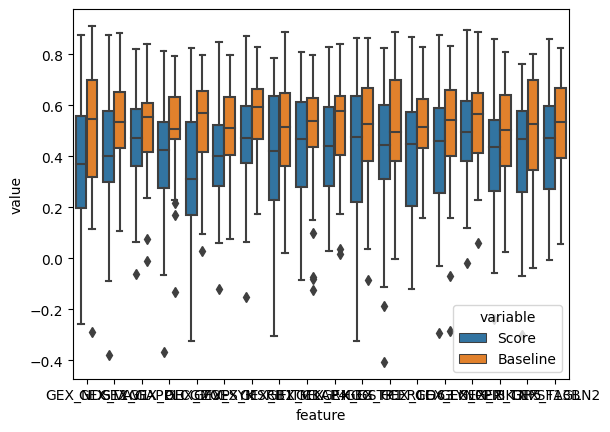

In [ ]:
sns.boxplot(data = total.melt(id_vars=['feature','Fold'],value_vars=['Score','Baseline']), x = 'feature', y = 'value', hue = 'variable')

In [ ]:
from sklearn.linear_model import LogisticRegression
hyperparam_search = {'alpha':[.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}
vals = HyperparamSearch()
vals_out = vals.run_search(params = hyperparam_search, cv_func = regular_ol_cv, cv_args = {'data':ds.data_normalized, 'features': features_sans_target+['age','Titre_IgG_PT'], 'target':'Target', 'n_splits':5, 'score_function':corr_coeff_report, 'model_class': Lasso})

In [ ]:
scores = pd.concat([x[0].assign(params = p) for p,x in enumerate(vals_out[0])])
scores['regularization'] = scores['params'].map(lambda x:vals_out[1][x]['alpha'])

In [ ]:
scores_flat = scores.melt(id_vars=['regularization'],value_vars=['Score','Baseline'])
ax = sns.boxplot(data = scores_flat, x = 'regularization', y = 'value', hue = 'variable')

In [ ]:
## Adapted from: https://alexmiller.phd/posts/linear-model-custom-loss-function-regularization-python/
##I added a second regularization, which is the "unreliabilities".
##This is intended to minimize coefficients for features that had
##conflicting correlation coefficients between batches.
##If no unreliabilities are supplied, that part of the loss
##disappears.

class CustomRidge:
    """
    Linear model: Y = XB, fit by minimizing the provided loss_function
    with L2 regularization
    """
    def __init__(self, loss_function=corr_coeff,
                 X=None, Y=None, sample_weights=None, beta_init=None,
                 regularization=0.000012, unreliabilities=None, method='nelder-mead'):
        self.regularization = regularization
        self.beta = None
        self.loss_function = loss_function
        self.sample_weights = sample_weights
        self.beta_init = beta_init
        self.unreliabilities = unreliabilities


    def predict(self, X):
        prediction = np.matmul(X, self.beta[:self.X.shape[1]])
        return(prediction)

    def model_error(self):
        error = self.loss_function(
            self.predict(self.X), self.Y
        )
        return(error)

    def l2_regularized_loss(self, beta):
        self.beta = beta
        print(self.beta)
        return(self.model_error() + \
               sum(self.regularization*np.array(self.beta[:self.X.shape[1]])**2)+
               sum(self.beta[:self.X.shape[1]]*self.beta[self.X.shape[1]:]))

    def fit(self, X, Y, maxiter=250):
        self.X = X
        self.Y = Y
        if type(self.unreliabilities) == type(None):
              self.unreliabilities = np.zeros(self.X.shape[1])
        if type(self.beta_init)==type(None):
            # set beta_init = 1 for every feature
            self.beta_init = np.hstack([np.array([1]*self.X.shape[1]),self.unreliabilities])
        else:
          self.beta_init = np.hstack([self.beta_init, self.unreliabilities])
          #  self.beta_init = np.reshape(np.stack([np.array([1]*self.X.shape[1]),self.unreliabilities], axis = 1), (2, self.X.shape[1], 2))

        if self.beta!=None and all(self.beta_init == self.beta):
            print("Model already fit once; continuing fit with more iterations.")
        print(self.beta_init)
        res = minimize(self.l2_regularized_loss, self.beta_init,
                       method='nelder-mead', options={'maxiter': 500})
        self.beta = res.x
        self.beta_init = self.beta
        self.coef_ = self.beta[:self.X.shape[1]]
        return self